# **Librerías**

In [ ]:
# Manipulación y análisis de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Manejo de rutas y sistema
import os
from pathlib import Path

# Machine Learning y preprocesamiento
import joblib
import time
from google.colab import files
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Descarga de datos desde Kaggle
import kagglehub

# Configuraciones generales
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


# **Base de datos de KaggleHub**

In [ ]:
# Descarga directa desde KaggleHub
path = kagglehub.dataset_download("patelris/crop-yield-prediction-dataset")
print("Ruta local de descarga:", path)

100%|██████████| 959k/959k [00:00<00:00, 81.5MB/s]

Extracting files...
Ruta local de descarga: /root/.cache/kagglehub/datasets/patelris/crop-yield-prediction-dataset/versions/1


# **Archivos presentes en la base de datos**

In [ ]:
# ============================================================
# Exploración inicial de archivos descargados desde Kaggle
# ============================================================

# Creamos el objeto base que representa la ruta raíz del dataset descargado
base = Path(path)

# Generamos una lista con todos los archivos dentro del directorio y sus subcarpetas
# rglob("*") busca recursivamente todos los archivos, y p.is_file() filtra solo los que son archivos (no carpetas)
files = [p for p in base.rglob("*") if p.is_file()]

# Mostramos la cantidad total de archivos encontrados y sus nombres con tamaños aproximados en KB
print(f"Archivos encontrados: {len(files)}")
for f in files:
    # f.stat().st_size obtiene el tamaño en bytes, que luego convertimos a KB
    print("-", f.name, f"({round(f.stat().st_size/1024, 1)} KB)")

# ------------------------------------------------------------
# Filtrado de archivos tabulares (CSV o Excel)
# ------------------------------------------------------------

# Definimos las extensiones que consideramos "tabulares"
tabular_exts = {".csv", ".xlsx", ".xls"}

# Filtramos solo los archivos con esas extensiones
tabular_files = [p for p in files if p.suffix.lower() in tabular_exts]

# Mostramos los nombres de los archivos tabulares encontrados
print("\n Archivos tabulares:", [f.name for f in tabular_files])

Archivos encontrados: 5
- rainfall.csv (133.5 KB)
- temp.csv (1388.1 KB)
- pesticides.csv (437.2 KB)
- yield_df.csv (1528.7 KB)
- yield.csv (3948.2 KB)

 Archivos tabulares: ['rainfall.csv', 'temp.csv', 'pesticides.csv', 'yield_df.csv', 'yield.csv']


# **Fusión de las bases de datos**

El objetivo es obtener una sola base consolidada (merged), con columnas limpias, sin duplicados y con nombres homogéneos, que servirá como insumo para la limpieza y análisis posteriores.

Se asegura que los datos estén en un formato consistente antes de aplicar modelos de Machine Learning.

In [ ]:
# ============================================================
# LECTURA, NORMALIZACIÓN Y FUSIÓN DE ARCHIVOS PRINCIPALES
# ============================================================

# 1. Función genérica para leer archivos CSV o Excel
def read_any(p: Path):
    """Lee archivos CSV o Excel con pandas según la extensión del archivo."""
    # Si el archivo termina en .csv se usa read_csv
    if p.suffix.lower() == ".csv":
        return pd.read_csv(p)
    # Si no, se asume que es un archivo de Excel
    else:
        return pd.read_excel(p)

# 2. Identificar los archivos principales dentro de la carpeta
# Se buscan los nombres que contienen palabras clave en minúsculas
# para asociarlos automáticamente a cada tipo de archivo
main_file = [f for f in tabular_files if "yield" in f.name.lower()][0]  # rendimiento
rain_file = [f for f in tabular_files if "rain" in f.name.lower()][0]   # lluvia
temp_file = [f for f in tabular_files if "temp" in f.name.lower()][0]   # temperatura
pest_file = [f for f in tabular_files if "pest" in f.name.lower()][0]   # pesticidas

# 3. Cargar cada dataset con la función genérica
df_yield = read_any(main_file)
df_rain = read_any(rain_file)
df_temp = read_any(temp_file)
df_pest = read_any(pest_file)

print("Archivos cargados correctamente.")
print("Formas:", df_yield.shape, df_rain.shape, df_temp.shape, df_pest.shape)

# ============================================================
# NORMALIZACIÓN DE NOMBRES DE COLUMNAS Y LIMPIEZA BÁSICA
# ============================================================

def normalize_cols(df):
    """
    Limpia los nombres de columnas y unifica los nombres de las variables clave.
    Esto facilita la posterior fusión entre tablas.
    """
    df = df.copy()

    # Elimina espacios y saltos de línea (\n o \r) en los nombres de las columnas
    df.columns = [c.strip().replace("\n", " ").replace("\r", " ").strip() for c in df.columns]

    # Elimina columnas duplicadas (si existen)
    df = df.loc[:, ~df.columns.duplicated()]

    # Diccionario para renombrar nombres clave según su significado
    rename_map = {}
    for c in df.columns:
        cl = c.lower()  # Se convierte a minúscula para comparar de forma uniforme
        if cl in {"area", "country", "nation"}:
            rename_map[c] = "Country"
        elif cl in {"year", "year code"}:
            rename_map[c] = "Year"
        elif cl in {"item", "crop", "commodity"}:
            rename_map[c] = "Item"
        elif "value" in cl:
            rename_map[c] = "Value"

    # Retorna el dataframe con columnas limpias y renombradas
    return df.rename(columns=rename_map)

# Aplicamos la normalización a los cuatro datasets
df_yield = normalize_cols(df_yield)
df_rain = normalize_cols(df_rain)
df_temp = normalize_cols(df_temp)
df_pest = normalize_cols(df_pest)

# Visualizamos las columnas finales de cada uno para verificar uniformidad
print("\n Columnas tras normalización:")
for name, df_ in zip(["Yield", "Rain", "Temp", "Pest"], [df_yield, df_rain, df_temp, df_pest]):
    print(f"{name}: {df_.columns.tolist()}")

# ============================================================
# VERIFICACIÓN DE DUPLICADOS EN CLAVES
# ============================================================

# Se revisa si alguna tabla tiene columnas repetidas
for name, df_ in zip(["Yield", "Rain", "Temp", "Pest"], [df_yield, df_rain, df_temp, df_pest]):
    if df_.columns.duplicated().any():
        print(f"{name} tiene columnas duplicadas, eliminando duplicadas...")
        df_ = df_.loc[:, ~df_.columns.duplicated()]

# ============================================================
# FUSIÓN PASO A PASO DE LOS DATASETS
# ============================================================

# Claves comunes entre los datasets (por país y año)
merge_keys = ["Country", "Year"]

def safe_merge(left, right, name, suffix):
    """
    Fusiona dos DataFrames de forma segura, eliminando duplicados y aplicando sufijos.
    Se asegura de no perder información y evitar nombres repetidos.
    """
    # Eliminar duplicadas antes de hacer el merge
    left = left.loc[:, ~left.columns.duplicated()]
    right = right.loc[:, ~right.columns.duplicated()]

    # Verificar las claves comunes presentes en ambos dataframes
    common = [k for k in merge_keys if k in left.columns and k in right.columns]
    print(f"Merging con {name} usando claves: {common}")

    # Realizar la fusión tipo "left" para conservar todos los datos del primer dataset
    merged = left.merge(right, on=common, how="left", suffixes=("", suffix))

    # Eliminar duplicadas después de la fusión (si quedaron)
    merged = merged.loc[:, ~merged.columns.duplicated()]
    return merged

# Fusión progresiva de todos los datasets en un único DataFrame
merged = safe_merge(df_yield, df_rain, "rain", "_rain")
merged = safe_merge(merged, df_temp, "temp", "_temp")
merged = safe_merge(merged, df_pest, "pest", "_pest")

# Resultado final del proceso de fusión
print("\n Fusión completada sin columnas duplicadas.")
print("Shape final:", merged.shape)
display(merged.head())

Archivos cargados correctamente.
Formas: (28242, 8) (6727, 3) (71311, 3) (4349, 7)

 Columnas tras normalización:
Yield: ['Unnamed: 0', 'Country', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']
Rain: ['Country', 'Year', 'average_rain_fall_mm_per_year']
Temp: ['Year', 'Country', 'avg_temp']
Pest: ['Domain', 'Country', 'Element', 'Item', 'Year', 'Unit', 'Value']
Merging con rain usando claves: ['Country', 'Year']
Merging con temp usando claves: ['Country', 'Year']
Merging con pest usando claves: ['Country', 'Year']

 Fusión completada sin columnas duplicadas.
Shape final: (186094, 15)


,Unnamed: 0,Country,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,average_rain_fall_mm_per_year_rain,avg_temp_temp,Domain,Element,Item_pest,Unit,Value
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0
1,1,Albania,Potatoes,1990,66667,1485.0,121.0,16.37,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0
2,2,Albania,"Rice, paddy",1990,23333,1485.0,121.0,16.37,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0
3,3,Albania,Sorghum,1990,12500,1485.0,121.0,16.37,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0
4,4,Albania,Soybeans,1990,7000,1485.0,121.0,16.37,1485,16.37,Pesticides Use,Use,Pesticides (total),tonnes of active ingredients,121.0


# **Columnas presentes en la base de datos**

In [ ]:
# Muestra en pantalla una lista con los nombres de todas las columnas del DataFrame "merged"
# Esto permite verificar que la fusión de los datasets fue correcta y que no existen duplicados o columnas inesperadas
print(merged.columns.tolist())

['Unnamed: 0', 'Country', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'average_rain_fall_mm_per_year_rain', 'avg_temp_temp', 'Domain', 'Element', 'Item_pest', 'Unit', 'Value']


# **Limpieza, depuración e imputación jerárquica**

In [ ]:
# ============================================================
# LIMPIEZA, DEPURACIÓN E IMPUTACIÓN JERÁRQUICA DEL DATASET
# ============================================================

# Se realiza una copia del dataset fusionado para evitar modificar el original
df = merged.copy()

# 1. Eliminación de columnas innecesarias o redundantes
# Se define una lista con los nombres de las columnas que no aportan valor analítico o son repetitivas
drop_cols = [
    'Domain Code', 'Domain', 'Area Code',
    'Element Code', 'Element', 'Unit',
    'Domain_pest', 'Element_pest', 'Item_pest', 'Unit_pest'
]
# Solo se eliminan las columnas que realmente existen en el DataFrame
drop_cols = [c for c in drop_cols if c in df.columns]
df = df.drop(columns=drop_cols)

# 2. Normalizar nombres de columnas (elimina espacios invisibles o saltos de línea)
df.columns = df.columns.str.strip()

# Se muestra el listado de columnas tras la limpieza inicial
print("Columnas después de limpieza inicial:", df.columns.tolist())

# 3. Definir la variable objetivo (target)
# La columna "Value" representa el rendimiento del cultivo (variable dependiente a predecir)
TARGET = "Value"
print(f"Columna objetivo (target): {TARGET}")

# 4. Conversión de columnas numéricas a tipo adecuado
# Convierte a tipo numérico las columnas seleccionadas; los valores no numéricos se transforman en NaN
num_cols = ['average_rain_fall_mm_per_year', 'avg_temp', 'Value_pest', TARGET]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 5. Eliminación de filas con valores nulos en la variable objetivo
# No es posible entrenar modelos de ML con observaciones sin valor objetivo
before = df.shape[0]
df = df.dropna(subset=[TARGET])
after = df.shape[0]
print(f"Filas eliminadas por target nulo: {before - after}")

# 6. Definición de función de imputación jerárquica
def hier_impute(df, col, group_keys):
    """
    Imputa valores faltantes en una columna usando un enfoque jerárquico.
    Prioriza la mediana por combinación de 'Country' y 'Item',
    luego por 'Country', después por 'Item' y finalmente usa la mediana global.
    """
    out = df[col].copy()
    available = [k for k in group_keys if k in df.columns]

    # 1. Imputación por combinación de claves (Country + Item)
    if len(available) == 2:
        out = out.fillna(df.groupby(available)[col].transform('median'))
    # 2. Imputación por país
    if 'Country' in df.columns:
        out = out.fillna(df.groupby('Country')[col].transform('median'))
    # 3. Imputación por cultivo o ítem
    if 'Item' in df.columns:
        out = out.fillna(df.groupby('Item')[col].transform('median'))
    # 4. Imputación global (mediana total de la columna)
    out = out.fillna(df[col].median())
    return out

# 7. Aplicación de imputación jerárquica a columnas numéricas predictoras
# Se define la jerarquía de imputación basada en 'Country' e 'Item'
group_keys = [k for k in ['Country', 'Item'] if k in df.columns]
# Se seleccionan las columnas numéricas a imputar
num_predictors = [c for c in ['average_rain_fall_mm_per_year', 'avg_temp', 'Value_pest'] if c in df.columns]

# Aplicación de la función a cada columna numérica predictora
for c in num_predictors:
    df[c] = hier_impute(df, c, group_keys)

# 8. Relleno de valores faltantes en variables categóricas con 'Unknown'
# Se identifican las columnas categóricas (tipo object, category o bool)
cat_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
for c in cat_cols:
    df[c] = df[c].fillna('Unknown')

# 9. Eliminación de filas duplicadas según claves principales
# Se asegura que cada combinación (Country, Item, Year) sea única
keys = [k for k in ['Country', 'Item', 'Year'] if k in df.columns]
before = df.shape[0]
df = df.sort_values(keys).drop_duplicates(subset=keys, keep='last')
after = df.shape[0]
print(f"Deduplicación por {keys}: {before} → {after}")

# Mensajes finales de verificación
print("Dataset limpio y listo para análisis.")
print("Shape final:", df.shape)
display(df.head(5))

Columnas después de limpieza inicial: ['Unnamed: 0', 'Country', 'Item', 'Year', 'hg/ha_yield', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp', 'average_rain_fall_mm_per_year_rain', 'avg_temp_temp', 'Value']
Columna objetivo (target): Value
Filas eliminadas por target nulo: 0
Deduplicación por ['Country', 'Item', 'Year']: 186094 → 13130
Dataset limpio y listo para análisis.
Shape final: (13130, 11)


,Unnamed: 0,Country,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,average_rain_fall_mm_per_year_rain,avg_temp_temp,Value
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37,1485,16.37,121.0
6,6,Albania,Maize,1991,29068,1485.0,121.0,15.36,1485,15.36,121.0
12,12,Albania,Maize,1992,24876,1485.0,121.0,16.06,1485,16.06,121.0
18,18,Albania,Maize,1993,24185,1485.0,121.0,16.05,1485,16.05,121.0
23,23,Albania,Maize,1994,25848,1485.0,201.0,16.96,1485,16.96,201.0


# **Exportación y descarga del dataset limpio**

In [ ]:
# ============================================================
# EXPORTACIÓN Y DESCARGA DEL DATASET LIMPIO
# ============================================================

# Se define la ruta donde se guardará el archivo CSV resultante
# En este caso, el archivo se almacenará en la carpeta principal de Colab
output_path = "/content/dataset_limpio.csv"

# Se exporta el DataFrame limpio (df) a formato CSV
# El parámetro index=False evita que la columna de índice se incluya en el archivo
df.to_csv(output_path, index=False)

# Mensaje de confirmación para verificar que el archivo fue guardado correctamente
print(f"Archivo limpio guardado correctamente en: {output_path}")

# Descarga del archivo directamente desde el entorno de Google Colab al computador local
# La función 'files.download()' permite obtener el archivo .csv generado
files.download(output_path)

Archivo limpio guardado correctamente en: /content/dataset_limpio.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Exploración general de la base de datos depurada**

Dimensiones del dataset (filas, columnas): (13130, 11)

Primeras 5 filas del dataset:


,Unnamed: 0,Country,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,average_rain_fall_mm_per_year_rain,avg_temp_temp,Value
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37,1485,16.37,121.0
6,6,Albania,Maize,1991,29068,1485.0,121.0,15.36,1485,15.36,121.0
12,12,Albania,Maize,1992,24876,1485.0,121.0,16.06,1485,16.06,121.0
18,18,Albania,Maize,1993,24185,1485.0,121.0,16.05,1485,16.05,121.0
23,23,Albania,Maize,1994,25848,1485.0,201.0,16.96,1485,16.96,201.0



--- Información general del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
Index: 13130 entries, 0 to 186093
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          13130 non-null  int64  
 1   Country                             13130 non-null  object 
 2   Item                                13130 non-null  object 
 3   Year                                13130 non-null  int64  
 4   hg/ha_yield                         13130 non-null  int64  
 5   average_rain_fall_mm_per_year       13130 non-null  float64
 6   pesticides_tonnes                   13130 non-null  float64
 7   avg_temp                            13130 non-null  float64
 8   average_rain_fall_mm_per_year_rain  13130 non-null  object 
 9   avg_temp_temp                       13130 non-null  float64
 10  Value                               13130 non-null  float64
dtypes:

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,13130.0,15098.833968,8650.897030,0.00,7451.50,17151.00,23363.75,28241.00
Year,13130.0,2001.622772,7.033139,1990.00,1995.00,2001.00,2008.00,2013.00
hg/ha_yield,13130.0,70968.615461,79124.283809,50.00,18000.00,39543.50,97152.25,501412.00
average_rain_fall_mm_per_year,13130.0,1157.238766,743.622488,51.00,608.00,1083.00,1651.00,3240.00
pesticides_tonnes,13130.0,14838.697886,33652.454670,0.04,264.53,2172.20,13335.22,367778.00
avg_temp,13130.0,19.858215,6.740940,1.30,16.01,20.87,25.85,30.65
avg_temp_temp,13130.0,19.858215,6.740940,1.30,16.01,20.87,25.85,30.65
Value,13130.0,14838.697886,33652.454670,0.04,264.53,2172.20,13335.22,367778.00



Número de registros por país:


,count
Country,
Cameroon,230
Kenya,230
Colombia,207
Brazil,207
Burundi,207
Peru,207
Rwanda,207
Mali,207
Uganda,207



Número de registros por tipo de cultivo:


,count
Item,
Potatoes,2091
Maize,2028
Wheat,1810
"Rice, paddy",1502
Sorghum,1435
Soybeans,1242
Sweet potatoes,1163
Cassava,941
Plantains and others,464



--- Matriz de correlación ---


,Unnamed: 0,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,avg_temp_temp,Value
Unnamed: 0,1.000000,0.007958,0.016521,-0.089581,-0.141295,-0.022203,-0.022203,-0.141295
Year,0.007958,1.000000,0.087800,-0.006962,0.084056,0.005208,0.005208,0.084056
hg/ha_yield,0.016521,0.087800,1.000000,0.013157,0.092209,-0.139113,-0.139113,0.092209
average_rain_fall_mm_per_year,-0.089581,-0.006962,0.013157,1.000000,0.077260,0.333879,0.333879,0.077260
pesticides_tonnes,-0.141295,0.084056,0.092209,0.077260,1.000000,-0.063469,-0.063469,1.000000
avg_temp,-0.022203,0.005208,-0.139113,0.333879,-0.063469,1.000000,1.000000,-0.063469
avg_temp_temp,-0.022203,0.005208,-0.139113,0.333879,-0.063469,1.000000,1.000000,-0.063469
Value,-0.141295,0.084056,0.092209,0.077260,1.000000,-0.063469,-0.063469,1.000000


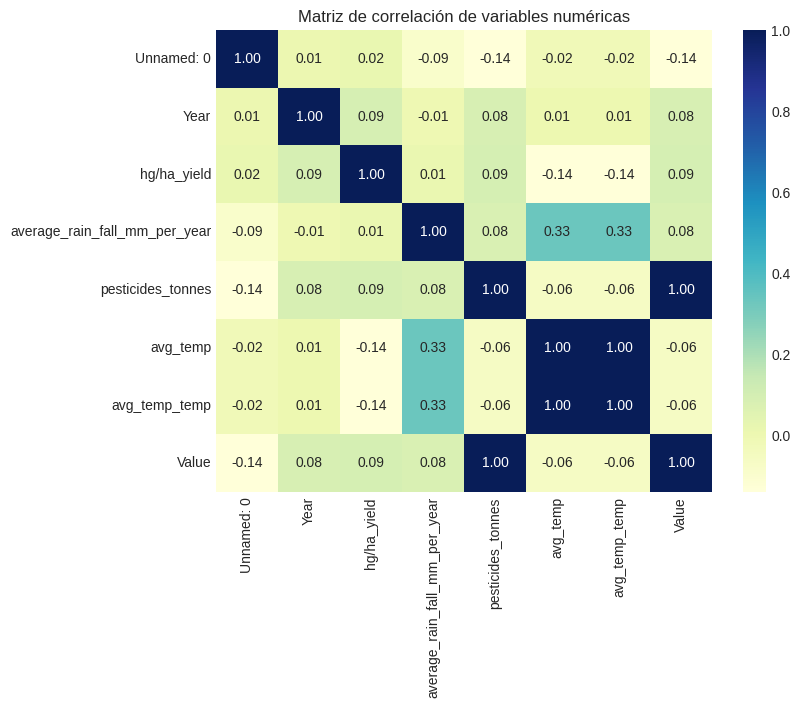

In [ ]:
# ============================================================
# ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ============================================================

# 1. Vista general del dataset
# Se imprimen las dimensiones del DataFrame (número de filas y columnas)
print("Dimensiones del dataset (filas, columnas):", df.shape)

# Se visualizan las primeras 5 filas del dataset para tener una idea general de la estructura
print("\nPrimeras 5 filas del dataset:")
display(df.head())

# 2. Información general sobre los tipos de datos y conteo de valores no nulos
# df.info() muestra el tipo de dato (numérico, texto, etc.) y la cantidad de valores válidos por columna
print("\n--- Información general del DataFrame ---")
df.info()

# 3. Verificación de valores nulos
# Se calcula el porcentaje de valores faltantes por columna
# isnull() detecta valores NaN, mean() calcula su proporción y sort_values() los ordena de mayor a menor
print("\n--- Porcentaje de valores nulos por columna ---")
print(df.isnull().mean().sort_values(ascending=False) * 100)

# 4. Resumen estadístico de las variables numéricas
# describe() calcula estadísticas básicas (media, desviación, mínimos, cuartiles, máximo)
# .T transpone el resultado para visualizarlo en formato vertical (por columnas)
print("\n--- Resumen estadístico de variables numéricas ---")
display(df.describe().T)

# 5. Distribución de registros por país y por tipo de cultivo
# value_counts() muestra cuántas observaciones tiene cada país o tipo de cultivo
# head(10) limita la salida a los 10 más frecuentes
print("\nNúmero de registros por país:")
display(df['Country'].value_counts().head(10))

print("\nNúmero de registros por tipo de cultivo:")
display(df['Item'].value_counts().head(10))

# 6. Correlación entre variables numéricas
# corr() calcula la correlación de Pearson entre variables numéricas
# numeric_only=True asegura que se incluyan solo columnas numéricas
print("\n--- Matriz de correlación ---")
corr = df.corr(numeric_only=True)
display(corr)

# 7. Visualización del mapa de calor de correlaciones
# Permite identificar relaciones entre variables predictoras y la variable objetivo

plt.figure(figsize=(8,6))
# sns.heatmap genera el mapa de calor (heatmap) de la matriz de correlación
# annot=True muestra los valores dentro de cada celda
# cmap define la paleta de colores (en este caso "YlGnBu" para tonos verdes y azules)
sns.heatmap(corr, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Matriz de correlación de variables numéricas")
plt.show()

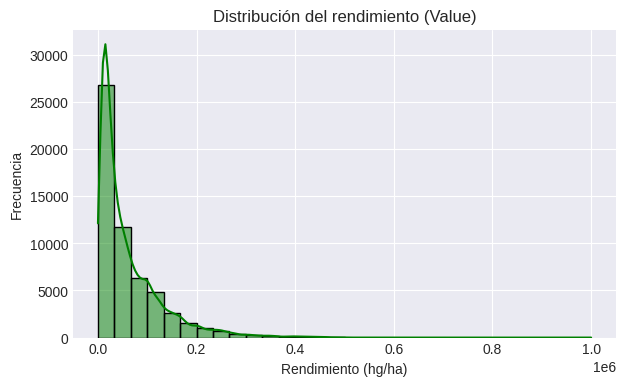

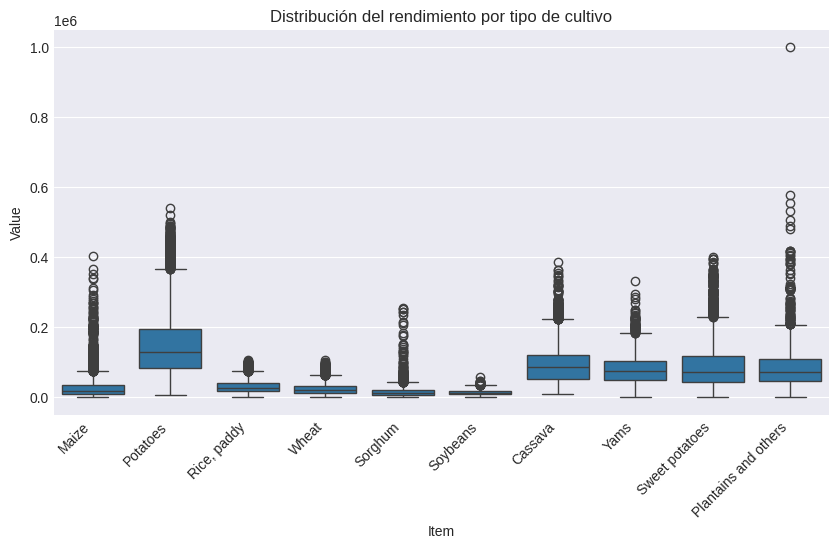

In [ ]:
# 1. Histograma del rendimiento (Value)
plt.figure(figsize=(7,4))
sns.histplot(df['Value'], bins=30, kde=True, color='green')
plt.title('Distribución del rendimiento (Value)')
plt.xlabel('Rendimiento (hg/ha)')
plt.ylabel('Frecuencia')
plt.show()

# 2. Boxplots comparativos por cultivo
plt.figure(figsize=(10,5))
sns.boxplot(data=df, x='Item', y='Value')
plt.xticks(rotation=45, ha='right')
plt.title('Distribución del rendimiento por tipo de cultivo')
plt.show()

# **Análisis Exploratorio de Datos (EDA)**

Dimensiones: (13130, 11)

Primeras filas del dataset:


,Unnamed: 0,Country,Item,Year,hg/ha_yield,average_rain_fall_mm_per_year,pesticides_tonnes,avg_temp,average_rain_fall_mm_per_year_rain,avg_temp_temp,Value
0,0,Albania,Maize,1990,36613,1485.0,121.0,16.37,1485,16.37,121.0
6,6,Albania,Maize,1991,29068,1485.0,121.0,15.36,1485,15.36,121.0
12,12,Albania,Maize,1992,24876,1485.0,121.0,16.06,1485,16.06,121.0
18,18,Albania,Maize,1993,24185,1485.0,121.0,16.05,1485,16.05,121.0
23,23,Albania,Maize,1994,25848,1485.0,201.0,16.96,1485,16.96,201.0



Porcentaje de nulos por columna:


,0
Unnamed: 0,0.0
Country,0.0
Item,0.0
Year,0.0
hg/ha_yield,0.0
average_rain_fall_mm_per_year,0.0
pesticides_tonnes,0.0
avg_temp,0.0
average_rain_fall_mm_per_year_rain,0.0
avg_temp_temp,0.0


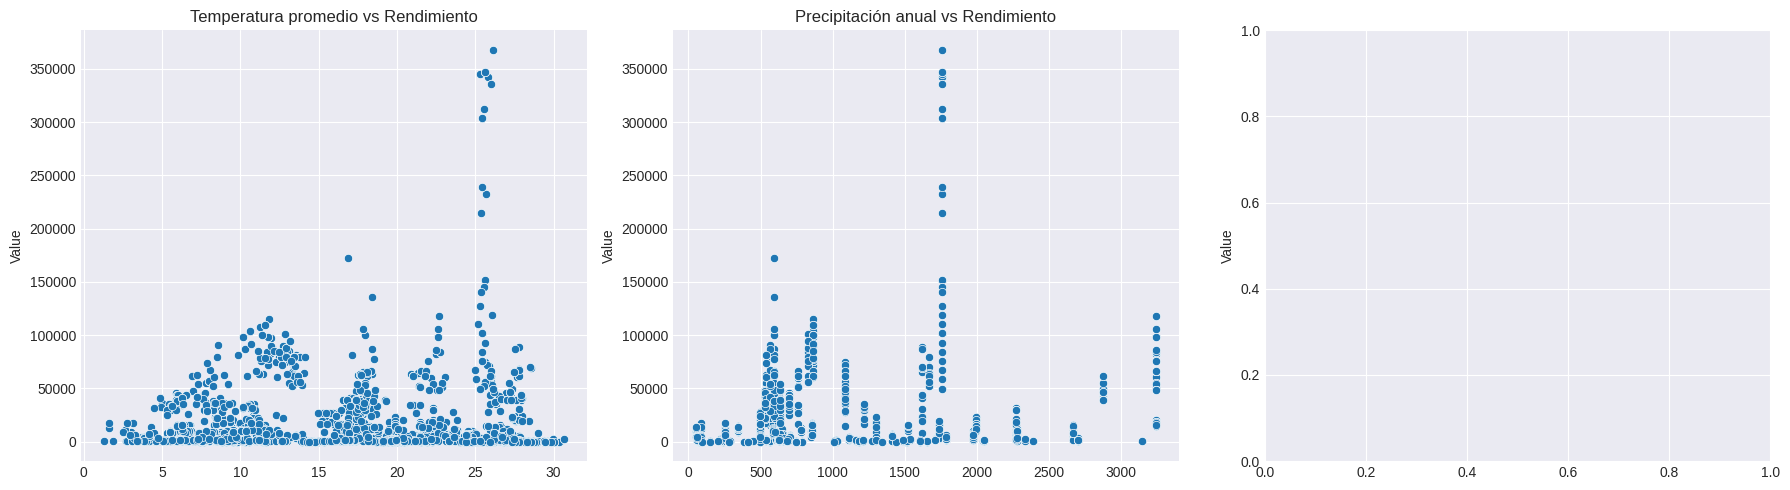

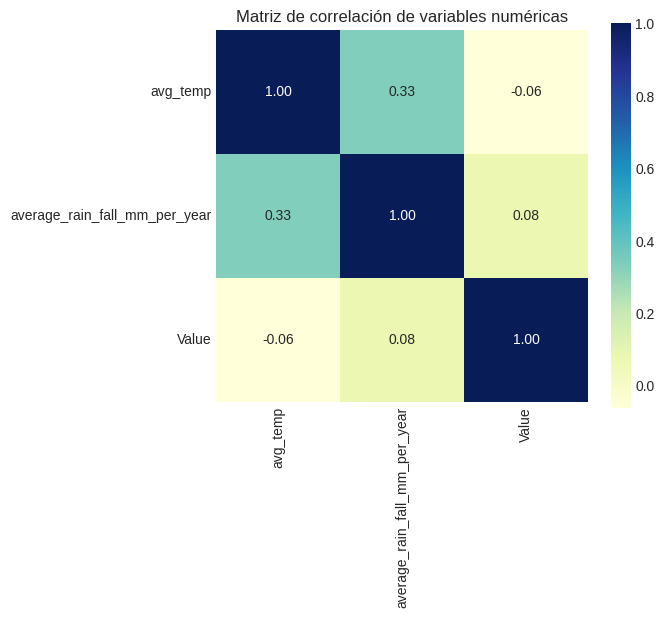

In [ ]:
# ============================================================
# ANÁLISIS DE RELACIONES ENTRE VARIABLES Y VALIDACIÓN DE ESTRUCTURA
# ============================================================

# Se asegura que exista la columna 'Value' (variable objetivo del modelo)
assert 'Value' in df.columns, "No se encontró la columna 'Value' (target)."

# Dimensiones generales del dataset (número de filas y columnas)
print("Dimensiones:", df.shape)

# Se muestran las primeras filas para verificar la estructura y tipos de datos
print("\nPrimeras filas del dataset:")
display(df.head())

# Se calcula y muestra el porcentaje de valores nulos por columna
# Esto permite identificar si aún existen vacíos tras la limpieza
print("\nPorcentaje de nulos por columna:")
display((df.isna().mean().sort_values(ascending=False) * 100).round(2))

# ------------------------------------------------------------
# Selección de columnas de interés para el análisis numérico y categórico
# ------------------------------------------------------------

# num_cols contendrá las variables numéricas relevantes (clima, pesticidas y rendimiento)
num_cols = [c for c in ['avg_temp', 'average_rain_fall_mm_per_year', 'Value_pest', 'Value'] if c in df.columns]

# cat_cols contendrá las variables categóricas (país y tipo de cultivo)
cat_cols = [c for c in ['Country', 'Item'] if c in df.columns]

# ------------------------------------------------------------
# Visualización de relaciones entre variables climáticas, de manejo y rendimiento
# ------------------------------------------------------------

# Se generan tres gráficos de dispersión (scatter plots) para observar relaciones entre:
# Temperatura promedio, precipitación anual, uso de pesticidas y rendimiento (Value)
fig, axes = plt.subplots(1, 3, figsize=(18,5))
axes = axes.ravel()

# Relación entre temperatura promedio y rendimiento
if 'avg_temp' in df.columns:
    sns.scatterplot(data=df.sample(min(len(df), 10000), random_state=42), x='avg_temp', y='Value', ax=axes[0])
    axes[0].set_title('Temperatura promedio vs Rendimiento')

# Relación entre precipitación anual y rendimiento
if 'average_rain_fall_mm_per_year' in df.columns:
    sns.scatterplot(data=df.sample(min(len(df), 10000), random_state=42),
                    x='average_rain_fall_mm_per_year', y='Value', ax=axes[1])
    axes[1].set_title('Precipitación anual vs Rendimiento')

# Relación entre uso de pesticidas y rendimiento
if 'Value_pest' in df.columns:
    sns.scatterplot(data=df.sample(min(len(df), 10000), random_state=42), x='Value_pest', y='Value', ax=axes[2])
    axes[2].set_title('Uso de pesticidas vs Rendimiento')

# Ajuste visual de etiquetas y espaciado entre los gráficos
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Cálculo y visualización de correlaciones entre variables numéricas
# ------------------------------------------------------------

# Se calcula la matriz de correlación entre las variables numéricas
corr = df[num_cols].corr(numeric_only=True)

# Se visualiza la matriz de correlación en un mapa de calor (heatmap)
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", square=True, cmap="YlGnBu")
plt.title('Matriz de correlación de variables numéricas')
plt.show()

# **Preprocesamiento (ColumnTransformer + Train/Test Split)**

In [ ]:
# ============================================================
# PREPROCESAMIENTO Y DIVISIÓN DE LOS DATOS
# ============================================================

# Se define la variable objetivo (target) que se busca predecir: 'Value'
# Esta variable representa el rendimiento agrícola (producción o productividad)
TARGET = 'Value'

# X contendrá todas las variables predictoras (independientes)
# y contendrá únicamente la variable objetivo (dependiente)
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(float)  # Se convierte a tipo float para asegurar compatibilidad con los modelos de ML

# ------------------------------------------------------------
# Identificación de columnas numéricas y categóricas
# ------------------------------------------------------------

# num_cols: Variables numéricas relacionadas con factores climáticos o de manejo
# cat_cols: Variables categóricas (regiones, países, cultivos)
num_cols = [c for c in ['avg_temp', 'average_rain_fall_mm_per_year', 'Value_pest'] if c in X.columns]
cat_cols = [c for c in ['Country', 'Item'] if c in X.columns]

print("Columnas numéricas:", num_cols)
print("Columnas categóricas:", cat_cols)

# ------------------------------------------------------------
# Definición de transformadores para el preprocesamiento
# ------------------------------------------------------------

# numeric_tf: pipeline para normalizar las variables numéricas
# StandardScaler() estandariza los datos restando la media y dividiendo por la desviación estándar
numeric_tf = Pipeline(steps=[('scaler', StandardScaler())])

# categorical_tf: pipeline para codificar variables categóricas
# OneHotEncoder convierte cada categoría en una columna binaria (0 o 1)
# handle_unknown='ignore' evita errores si aparecen categorías nuevas en el conjunto de prueba
categorical_tf = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# ------------------------------------------------------------
# ColumnTransformer: combina los dos tipos de transformaciones en un solo objeto
# ------------------------------------------------------------

# Aplica las transformaciones numéricas y categóricas al mismo tiempo antes del entrenamiento
# 'remainder=drop' descarta cualquier otra columna que no esté en num_cols o cat_cols
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, num_cols),
        ('cat', categorical_tf, cat_cols)
    ],
    remainder='drop'
)

# ------------------------------------------------------------
# División de los datos en entrenamiento y prueba
# ------------------------------------------------------------

# train_test_split separa el dataset en 80% para entrenamiento y 20% para prueba
# random_state=42 garantiza reproducibilidad (los mismos datos se usarán en cada ejecución)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Se imprimen las dimensiones de los conjuntos generados
print("Tamaños -> X_train:", X_train.shape, "| X_test:", X_test.shape)

Columnas numéricas: ['avg_temp', 'average_rain_fall_mm_per_year']
Columnas categóricas: ['Country', 'Item']
Tamaños -> X_train: (10504, 10) | X_test: (2626, 10)


# **CELDA HELPER: utilidades de evaluación y visualización**

In [ ]:
# ============================================================
# CELDA HELPER — FUNCIONES DE APOYO PARA ENTRENAMIENTO Y EVALUACIÓN
# ============================================================

# Esta celda define funciones auxiliares reutilizables (helpers)
# que automatizan el proceso de entrenamiento, evaluación y comparación de modelos.
# Permite mantener un flujo uniforme para calcular métricas, graficar resultados
# y analizar el rendimiento de distintos algoritmos de Machine Learning.

# ------------------------------------------------------------
# 1. Función RMSE
# ------------------------------------------------------------
def rmse(y_true, y_pred):
    """Calcula la raíz del error cuadrático medio (Root Mean Squared Error).
    Mide la magnitud promedio del error de predicción en las mismas unidades que la variable objetivo."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

# ------------------------------------------------------------
# 2. Función train_and_eval()
# ------------------------------------------------------------
def train_and_eval(pipeline, X_train, y_train, X_test, y_test, name="Modelo"):
    """
    Entrena un pipeline de Machine Learning, genera predicciones y evalúa el modelo con métricas estándar.
    Retorna un diccionario con resultados clave.

    Parámetros:
      - pipeline: modelo encapsulado con el preprocesamiento.
      - X_train, y_train: datos de entrenamiento.
      - X_test, y_test: datos de prueba.
      - name: nombre identificador del modelo.
    """

    # Se mide el tiempo de entrenamiento para comparar eficiencia entre modelos
    t0 = time.time()
    pipeline.fit(X_train, y_train)
    t1 = time.time()

    # Se generan las predicciones sobre los datos de prueba
    y_pred = pipeline.predict(X_test)

    # Se calculan las métricas principales:
    # - MAE: Error absoluto medio
    # - RMSE: Raíz del error cuadrático medio
    # - R²: Coeficiente de determinación (qué tan bien se ajusta el modelo)
    metrics = {
        "Modelo": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": rmse(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "Tiempo (s)": t1 - t0
    }

    # Se imprime un resumen de resultados en formato estandarizado
    print(f"Resultados - {name}")
    print(f"MAE : {metrics['MAE']:.6f}")
    print(f"RMSE: {metrics['RMSE']:.6f}")
    print(f"R²  : {metrics['R2']:.6f}")
    print(f"Tiempo de entrenamiento: {metrics['Tiempo (s)']:.2f} s")

    return metrics

# ------------------------------------------------------------
# 3. Función consolidate_results()
# ------------------------------------------------------------
def consolidate_results(*dicts):
    """
    Consolida múltiples diccionarios de métricas (uno por modelo)
    en un único DataFrame ordenado de menor a mayor RMSE.
    Facilita la comparación objetiva del desempeño entre modelos.
    """
    df = pd.DataFrame(list(dicts)).sort_values("RMSE").reset_index(drop=True)
    return df

# ------------------------------------------------------------
# 4. Función plot_results()
# ------------------------------------------------------------
def plot_results(results_df):
    """
    Genera gráficos comparativos de las métricas MAE, RMSE y R² para cada modelo evaluado.
    Se espera un DataFrame con columnas ['Modelo', 'MAE', 'RMSE', 'R2'].
    """

    # Validación: se asegura que el DataFrame contenga las columnas esperadas
    if not {"Modelo", "MAE", "RMSE", "R2"}.issubset(results_df.columns):
        raise ValueError("El DataFrame de resultados debe contener las columnas: Modelo, MAE, RMSE, R2.")

    # Se crean tres gráficos de barras horizontales, uno por cada métrica principal
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    axes = axes.ravel()

    # MAE (Error Absoluto Medio)
    axes[0].barh(results_df["Modelo"], results_df["MAE"])
    axes[0].set_title("MAE por modelo")
    axes[0].invert_yaxis()

    # RMSE (Error Cuadrático Medio)
    axes[1].barh(results_df["Modelo"], results_df["RMSE"])
    axes[1].set_title("RMSE por modelo")
    axes[1].invert_yaxis()

    # R² (Coeficiente de determinación)
    axes[2].barh(results_df["Modelo"], results_df["R2"])
    axes[2].set_title("R² por modelo")
    axes[2].invert_yaxis()

    # Ajuste de espaciado entre subgráficos
    plt.tight_layout()
    plt.show()

# **Entrenamiento de los modelos**

# ***Regresión Lineal***

El modelo de Regresión Lineal es un algoritmo de aprendizaje supervisado, ya que utiliza datos de entrada junto con una variable objetivo conocida (Value) para aprender la relación entre las variables predictoras como temperatura, precipitación, uso de pesticidas y el rendimiento agrícola. Su objetivo es estimar una función lineal que minimice el error entre los valores reales y las predicciones, permitiendo realizar estimaciones continuas del rendimiento de los cultivos

In [ ]:
# ============================================================
# ENTRENAMIENTO DEL MODELO 1 — REGRESIÓN LINEAL
# ============================================================

# Se construye un pipeline que integra dos etapas:
# 1) 'preprocess': aplica las transformaciones definidas previamente (escalado y codificación)
# 2) 'model': instancia el modelo de Regresión Lineal
pipe_lr = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', LinearRegression())
])

# ------------------------------------------------------------
# Entrenamiento del modelo
# ------------------------------------------------------------

# Se mide el tiempo de entrenamiento para evaluar la eficiencia computacional
start = time.time()
pipe_lr.fit(X_train, y_train)  # Ajusta el modelo con los datos de entrenamiento
end = time.time()

# ------------------------------------------------------------
# Predicciones y evaluación
# ------------------------------------------------------------

# Se generan las predicciones del modelo sobre los datos de prueba (X_test)
pred_lr = pipe_lr.predict(X_test)

# Cálculo de métricas de desempeño:
# - MAE (Mean Absolute Error): error promedio en las predicciones
# - RMSE (Root Mean Squared Error): magnitud promedio del error en las mismas unidades que la variable objetivo
# - R² (Coeficiente de determinación): mide qué proporción de la varianza del rendimiento (Value) explica el modelo
mae_lr = mean_absolute_error(y_test, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, pred_lr))
r2_lr = r2_score(y_test, pred_lr)

# ------------------------------------------------------------
# Resultados del modelo
# ------------------------------------------------------------

# Se imprimen las métricas principales para evaluar la precisión y el ajuste del modelo
print("Resultados - Regresión Lineal:")
print(f"MAE: {mae_lr:.3f}")
print(f"RMSE: {rmse_lr:.3f}")
print(f"R²: {r2_lr:.3f}")
print(f"Tiempo de entrenamiento: {end - start:.2f} s")

Resultados - Regresión Lineal:
MAE: 27190.399
RMSE: 40418.385
R²: 0.649
Tiempo de entrenamiento: 1.11 s


# ***Random Forest***

El modelo Random Forest Regressor es un algoritmo de aprendizaje supervisado basado en el ensamblaje de múltiples árboles de decisión, donde cada árbol aprende a predecir una parte del resultado y la media de sus predicciones mejora la precisión general.

Este método reduce el sobreajuste típico de los árboles individuales y maneja de manera robusta relaciones no lineales entre las variables, lo que lo hace especialmente útil en contextos agrícolas donde factores como temperatura, lluvia y uso de pesticidas presentan interacciones complejas.

In [ ]:
# ============================================================
# ENTRENAMIENTO DEL MODELO 2 — RANDOM FOREST REGRESSOR
# ============================================================

# Se construye un pipeline con dos etapas:
# 1) 'preprocess': aplica el preprocesamiento definido (escalado y codificación)
# 2) 'model': instancia un Random Forest para regresión
pipe_rf = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(
        n_estimators=400,      # número de árboles en el bosque
        max_depth=20,          # profundidad máxima de cada árbol (controla sobreajuste)
        min_samples_leaf=2,    # mínimo de muestras por hoja (suaviza el modelo)
        random_state=42,       # semilla aleatoria para reproducibilidad
        n_jobs=-1              # usa todos los núcleos del procesador para acelerar el entrenamiento
    ))
])

# ------------------------------------------------------------
# Entrenamiento del modelo
# ------------------------------------------------------------

# Se mide el tiempo total de entrenamiento
start = time.time()
pipe_rf.fit(X_train, y_train)  # Ajuste del modelo con los datos de entrenamiento
end = time.time()

# ------------------------------------------------------------
# Predicción y evaluación del modelo
# ------------------------------------------------------------

# Se generan las predicciones sobre el conjunto de prueba
pred_rf = pipe_rf.predict(X_test)

# Cálculo de métricas de rendimiento
# - MAE: error medio absoluto
# - RMSE: raíz del error cuadrático medio
# - R²: proporción de varianza explicada
mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf = r2_score(y_test, pred_rf)

# ------------------------------------------------------------
# Resultados del modelo
# ------------------------------------------------------------

print("Resultados - Random Forest:")
print(f"MAE: {mae_rf:.3f}")
print(f"RMSE: {rmse_rf:.3f}")
print(f"R²: {r2_rf:.3f}")
print(f"Tiempo de entrenamiento: {end - start:.2f} s")

Resultados - Random Forest:
MAE: 14328.396
RMSE: 24678.164
R²: 0.869
Tiempo de entrenamiento: 238.16 s


# ***Gradient Boosting***

El modelo Gradient Boosting Regressor es un método de aprendizaje supervisado basado en el principio del boosting, donde múltiples modelos débiles (árboles de decisión poco profundos) se combinan secuencialmente para corregir los errores de sus predecesores.

Cada nuevo árbol se ajusta a los residuos del modelo anterior, mejorando progresivamente la capacidad predictiva del conjunto.

In [ ]:
# ============================================================
# ENTRENAMIENTO DEL MODELO 3 — GRADIENT BOOSTING REGRESSOR
# ============================================================

# Se construye un pipeline con dos pasos:
# 1) 'preprocess': aplica el preprocesamiento definido (escalado y codificación)
# 2) 'model': instancia el modelo Gradient Boosting para regresión
pipe_gb = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', GradientBoostingRegressor(
        n_estimators=400,     # número de árboles a entrenar de manera secuencial
        learning_rate=0.05,   # tasa de aprendizaje (peso dado a cada árbol sucesivo)
        max_depth=3,          # profundidad máxima de cada árbol base
        random_state=42       # semilla para garantizar reproducibilidad
    ))
])

# ------------------------------------------------------------
# Entrenamiento del modelo
# ------------------------------------------------------------

# Se mide el tiempo total de entrenamiento para evaluar la eficiencia computacional
start = time.time()
pipe_gb.fit(X_train, y_train)  # Ajusta el modelo con los datos de entrenamiento
end = time.time()

# ------------------------------------------------------------
# Predicciones y evaluación
# ------------------------------------------------------------

# Se generan las predicciones sobre los datos de prueba (X_test)
pred_gb = pipe_gb.predict(X_test)

# Cálculo de métricas de rendimiento
# - MAE: error absoluto medio
# - RMSE: raíz del error cuadrático medio
# - R²: coeficiente de determinación
mae_gb = mean_absolute_error(y_test, pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, pred_gb))
r2_gb = r2_score(y_test, pred_gb)

# ------------------------------------------------------------
# Resultados del modelo
# ------------------------------------------------------------

print("Resultados - Gradient Boosting:")
print(f"MAE: {mae_gb:.3f}")
print(f"RMSE: {rmse_gb:.3f}")
print(f"R²: {r2_gb:.3f}")
print(f"Tiempo de entrenamiento: {end - start:.2f} s")

Resultados - Gradient Boosting:
MAE: 23243.643
RMSE: 36366.142
R²: 0.716
Tiempo de entrenamiento: 156.44 s


# **Guardar entrenamiento de los modelos**

In [ ]:
# ============================================================
# GUARDADO DE RESULTADOS Y MODELOS ENTRENADOS
# ============================================================

# ------------------------------------------------------------
# Crear carpeta de salida
# ------------------------------------------------------------

# Crea una carpeta llamada "resultados_modelos" en el directorio actual
# El parámetro exist_ok=True evita errores si la carpeta ya existe
os.makedirs("resultados_modelos", exist_ok=True)

# ------------------------------------------------------------
# Guardar las métricas de evaluación de los modelos
# ------------------------------------------------------------

# Se define la ruta del archivo CSV donde se almacenarán las métricas de comparación
results_path = "resultados_modelos/resultados_comparativos.csv"

# Se exporta el DataFrame 'results_df' con las métricas (MAE, RMSE, R², tiempo)
results_df.to_csv(results_path, index=False)
print(f"Métricas guardadas en: {results_path}")

# ------------------------------------------------------------
# Guardar los modelos entrenados
# ------------------------------------------------------------

# Se crea un diccionario con los nombres de archivo y los modelos correspondientes
models = {
    "regresion_lineal.pkl": pipe_lr,
    "random_forest.pkl": pipe_rf,
    "gradient_boosting.pkl": pipe_gb
}

# Cada modelo (pipeline completo) se guarda en formato .pkl mediante joblib
# Esto permite reutilizarlos en futuros análisis sin necesidad de reentrenar
for filename, model in models.items():
    model_path = os.path.join("resultados_modelos", filename)
    joblib.dump(model, model_path)
    print(f"Modelo guardado: {model_path}")

# ------------------------------------------------------------
# Guardar las predicciones para análisis posterior (opcional)
# ------------------------------------------------------------

# Se genera un DataFrame que contiene los valores reales (y_true)
# y las predicciones de cada modelo (Linear, RF, GB)
preds_df = pd.DataFrame({
    "y_true": y_test,
    "pred_lr": pred_lr,
    "pred_rf": pred_rf,
    "pred_gb": pred_gb
})

# Se define la ruta del archivo CSV donde se guardarán las predicciones
preds_path = "resultados_modelos/predicciones.csv"

# Exportación de las predicciones a formato CSV
preds_df.to_csv(preds_path, index=False)
print(f"Predicciones guardadas en: {preds_path}")

Métricas guardadas en: resultados_modelos/resultados_comparativos.csv
Modelo guardado: resultados_modelos/regresion_lineal.pkl
Modelo guardado: resultados_modelos/random_forest.pkl
Modelo guardado: resultados_modelos/gradient_boosting.pkl
Predicciones guardadas en: resultados_modelos/predicciones.csv


# **Comparación general de resultados (tabla + gráficos)**

Resultados comparativos:


,Modelo,MAE,RMSE,R2
0,Random Forest,14328.396229,24678.164257,0.869052
1,Gradient Boosting,23243.643147,36366.142276,0.715641
2,Regresión Lineal,27190.399258,40418.385368,0.648739


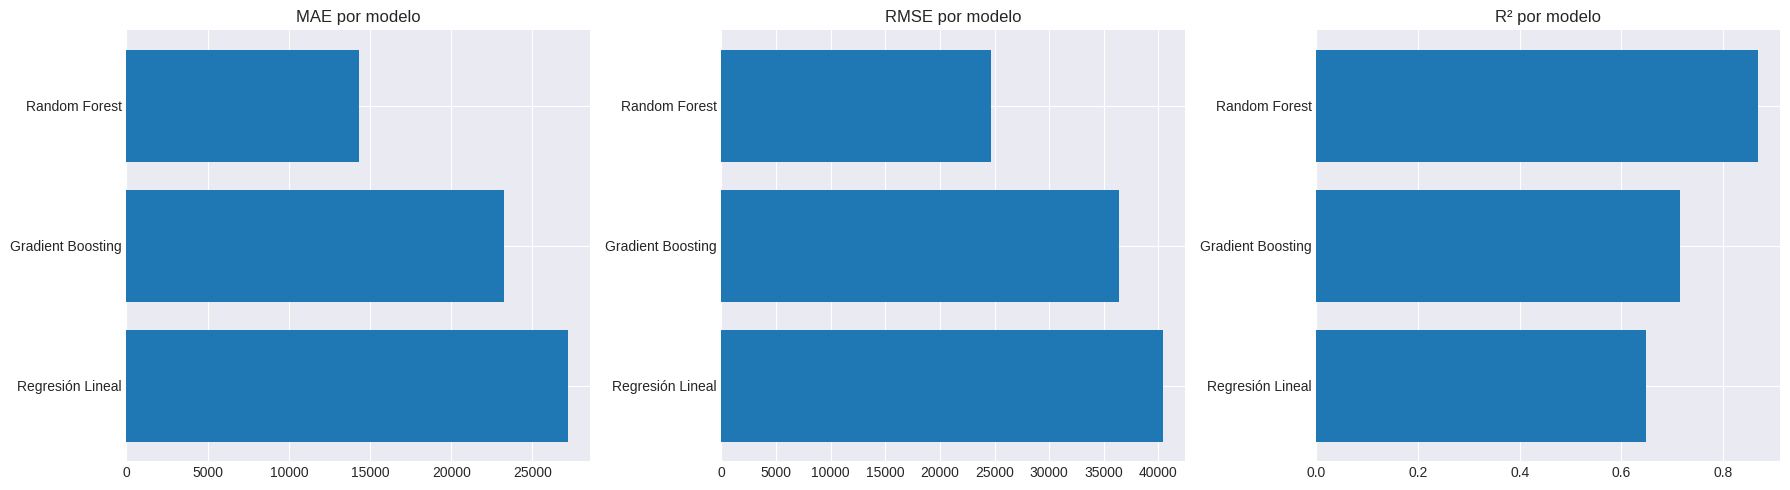

Mejor modelo por RMSE: Random Forest


In [ ]:
# ============================================================
# COMPARACIÓN DE RESULTADOS ENTRE MODELOS
# ============================================================

# ------------------------------------------------------------
# Creación del DataFrame de resultados
# ------------------------------------------------------------

# Detecta si el usuario usó las funciones HELPER (train_and_eval)
# que generan diccionarios de métricas (res_lr, res_rf, res_gb)
# o si los valores fueron definidos de forma manual (mae_*, rmse_*, r2_*)

try:
    # Si se usaron los helpers, consolida los resultados automáticamente
    results_df = consolidate_results(res_lr, res_rf, res_gb)
except:
    # Si no existen diccionarios, crea el DataFrame manualmente con las métricas calculadas
    results_df = pd.DataFrame({
        'Modelo': ['Regresión Lineal', 'Random Forest', 'Gradient Boosting'],
        'MAE': [mae_lr, mae_rf, mae_gb],
        'RMSE': [rmse_lr, rmse_rf, rmse_gb],
        'R2': [r2_lr, r2_rf, r2_gb]
    }).sort_values('RMSE').reset_index(drop=True)

# Se imprimen los resultados comparativos ordenados por RMSE (menor a mayor error)
print("Resultados comparativos:")
display(results_df)

# ------------------------------------------------------------
# Gráficos comparativos de métricas por modelo
# ------------------------------------------------------------

# Se generan tres gráficos de barras horizontales (uno por métrica: MAE, RMSE y R²)
fig, axes = plt.subplots(1, 3, figsize=(18,5))
axes = axes.ravel()

# MAE (Mean Absolute Error): error promedio absoluto
axes[0].barh(results_df['Modelo'], results_df['MAE'])
axes[0].set_title('MAE por modelo')
axes[0].invert_yaxis()  # ordena visualmente de mejor a peor

# RMSE (Root Mean Squared Error): magnitud promedio del error
axes[1].barh(results_df['Modelo'], results_df['RMSE'])
axes[1].set_title('RMSE por modelo')
axes[1].invert_yaxis()

# R² (Coeficiente de determinación): medida de ajuste del modelo a los datos
axes[2].barh(results_df['Modelo'], results_df['R2'])
axes[2].set_title('R² por modelo')
axes[2].invert_yaxis()

# Ajuste del diseño visual
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Identificación del mejor modelo
# ------------------------------------------------------------

# Se identifica el modelo con menor RMSE, que representa menor error de predicción promedio
best_model_name = results_df.loc[results_df['RMSE'].idxmin(), 'Modelo']
print(f"Mejor modelo por RMSE: {best_model_name}")

# **Diagnóstico de errores y paridad + importancia de variables**

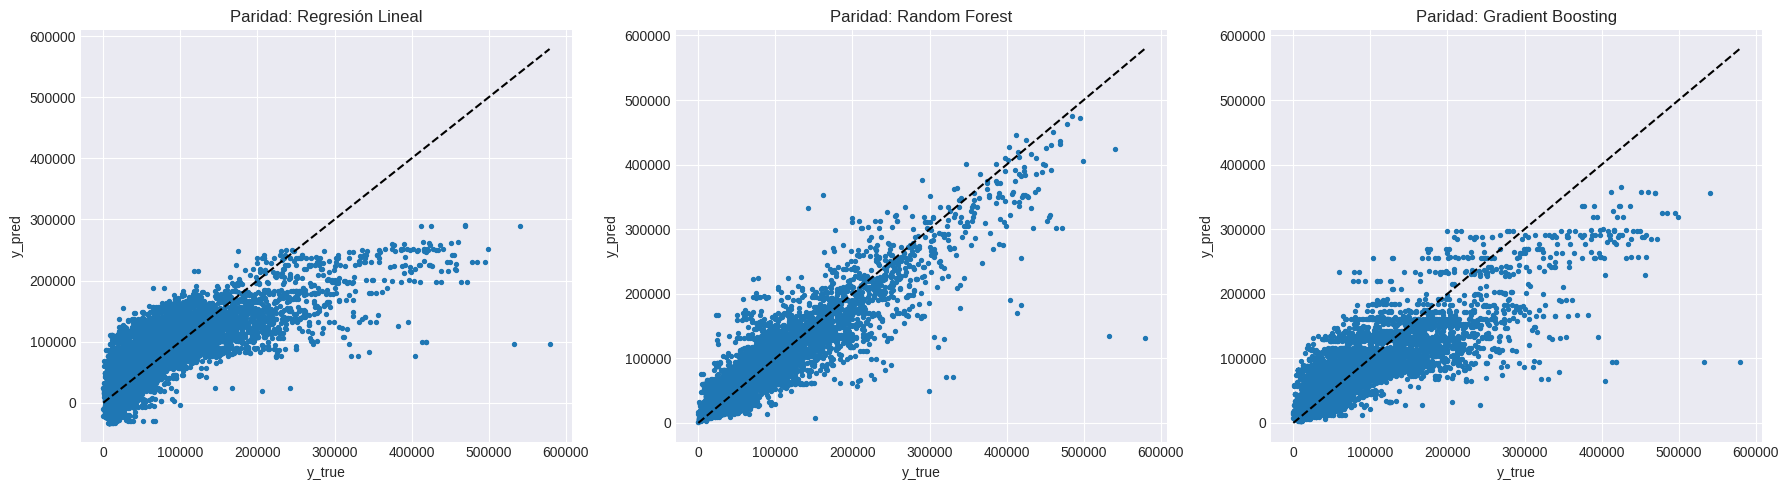

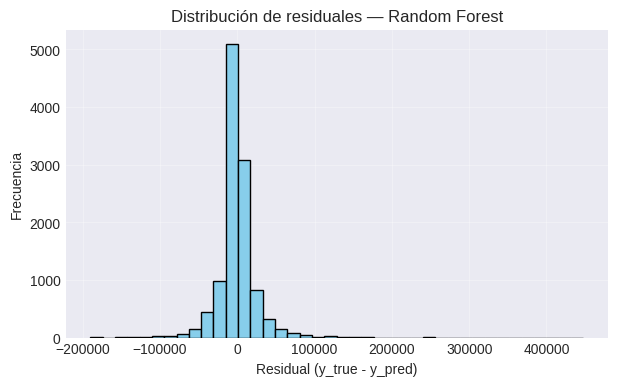

In [ ]:
# ============================================================
# ANÁLISIS VISUAL DEL COMPORTAMIENTO DE LOS MODELOS
# ============================================================

# ------------------------------------------------------------
# 1) Reconstrucción de predicciones (por seguridad)
# ------------------------------------------------------------

# Si alguna variable de predicción no existe (por ejemplo, si se reinició el entorno),
# se generan nuevamente las predicciones con los modelos entrenados
try:
    pred_lr
except:
    pred_lr = pipe_lr.predict(X_test)
try:
    pred_rf
except:
    pred_rf = pipe_rf.predict(X_test)
try:
    pred_gb
except:
    pred_gb = pipe_gb.predict(X_test)

# ------------------------------------------------------------
# 2) Gráficos de paridad (predicción vs valor real)
# ------------------------------------------------------------

# Estos gráficos comparan las predicciones (y_pred) con los valores reales (y_true)
# para cada modelo, permitiendo observar qué tan bien se ajustan los resultados.
# Una distribución cercana a la línea diagonal indica un buen ajuste.

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18,5))
axes = axes.ravel()

# --- Regresión Lineal ---
axes[0].scatter(y_test, pred_lr, s=8)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')  # línea de referencia (y=x)
axes[0].set_title('Paridad: Regresión Lineal')
axes[0].set_xlabel('y_true')
axes[0].set_ylabel('y_pred')

# --- Random Forest ---
axes[1].scatter(y_test, pred_rf, s=8)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[1].set_title('Paridad: Random Forest')
axes[1].set_xlabel('y_true')
axes[1].set_ylabel('y_pred')

# --- Gradient Boosting ---
axes[2].scatter(y_test, pred_gb, s=8)
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
axes[2].set_title('Paridad: Gradient Boosting')
axes[2].set_xlabel('y_true')
axes[2].set_ylabel('y_pred')

# Ajuste visual general
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 3) Distribución de residuales del mejor modelo
# ------------------------------------------------------------

# Se evalúan los errores (residuales) del modelo con menor RMSE.
# Los residuales son la diferencia entre el valor real (y_true) y la predicción (y_pred).
# Un buen modelo debe tener residuales centrados en 0 y con distribución simétrica.

model_map = {
    'Regresión Lineal': (pipe_lr, pred_lr),
    'Random Forest': (pipe_rf, pred_rf),
    'Gradient Boosting': (pipe_gb, pred_gb)
}

# Si no existe la variable best_model_name (por algún error previo), se usa Gradient Boosting por defecto
best_name = best_model_name if 'best_model_name' in locals() else 'Gradient Boosting'
best_pipe, best_pred = model_map[best_name]

# Cálculo de los residuales
residuals = y_test - best_pred

# Visualización de la distribución de residuales
plt.figure(figsize=(7,4))
plt.hist(residuals, bins=40, color='skyblue', edgecolor='black')
plt.title(f'Distribución de residuales — {best_name}')
plt.xlabel('Residual (y_true - y_pred)')
plt.ylabel('Frecuencia')
plt.grid(alpha=0.3)
plt.show()